In [2]:
%matplotlib inline

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import pandas as pd
import csv
from scipy import stats

# pour "jeje":
#file="/Users/jeje/Documents/Scolaire/M2/Projet_DFE/doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"
# pour "nana":
file="../doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"

In [4]:
from IPython.display import display, HTML, Video
CSS = """.output {align-items: center;}"""
HTML('<style>{}</style>'.format(CSS))

In [5]:
tmax=10000
ncells=1475

# Importer les données réelles

In [6]:
growthR_real_df = pd.read_csv(file, 
                      sep = ";", 
                      decimal=",", 
                      usecols=range(2,1476*3+1,3), 
                      skiprows=[1,2])
growthR_real_df.iloc[:5, :5]

,growth.rate,growth.rate.1,growth.rate.2,growth.rate.3,growth.rate.4
0,0.03527,0.032026,0.028119,0.029765,NaN
1,0.03527,0.032026,0.028119,0.029765,0.033812
2,0.03247,0.032026,0.026802,0.030567,0.033812
3,0.03247,0.032026,0.026802,0.030567,0.033812
4,0.03247,0.033672,0.026802,0.030567,0.033812


In [41]:
growthR_real_array = growthR_real_df.to_numpy()

In [8]:
exp_shape = (tmax, ncells)#np.shape(growthR_real_array)
print(exp_shape)

(10000, 1475)


In [42]:
growthR_real_array

array([[3.5269650e-02, 3.2025912e-02, 2.8119496e-02, ..., 2.3454689e-02,
        1.8758796e-02,           nan],
       [3.5269650e-02, 3.2025912e-02, 2.8119496e-02, ..., 2.3454689e-02,
        1.8758796e-02, 2.5567243e-02],
       [3.2470449e-02, 3.2025912e-02, 2.6801815e-02, ..., 2.6620318e-02,
        3.0876094e-02, 2.5567243e-02],
       ...,
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00],
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00],
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00]])

In [45]:
# Distribution initiale des taux de croissances
#growthR_init = growthR_real_array[:,0]   # première génération de l'expérience (comprenant des taux de croissance aberrants et des NAs)
growthR_init = np.array([np.median([l for l in d if not np.isnan(l)]) for d in growthR_real_array.T[:,:10]])   # médiane des 10 premières mesures
growthR_init[growthR_init<0] = 0          # retirer la valeur de taux de croissance négative aberrante

# Simulations

In [63]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
exp_duration = tmax*4#4000       # durée de l'expérience, en minutes
mut_shape = (int(exp_duration*mutation_rate*5), 1476)  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)
constant_mut_rate = False # on choisit si le taux de mutation est constant

# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, exp_duration, 4, dtype=float)

# Bruit sur les mesures
sd_noise = 0.1          # Écart-type bruit additif gaussien

mut_shape

(1066, 1476)

In [64]:
# Paramètres de la distribution Beta fittée comme DFE dans l'article
alpha=0.0074
beta=2.4

esp=alpha/(alpha+beta)
var=alpha*beta/((alpha+beta)**2*(alpha+beta+1))
asym=2*(beta-alpha)*np.sqrt(alpha+beta+1)/((alpha+beta+2)*np.sqrt(alpha*beta))
kurtosis=6*(beta-alpha)**2*(alpha+beta+1)-alpha*beta*(alpha+beta+2)/(alpha*beta*(alpha+beta+2)*(alpha+beta+3))

print("Espérance de la loi simulée:",esp)
print("Espérance à obtenir: 0.0031")
print("CV de la loi simulée:",np.sqrt(var)/esp)
print("CV à obtenir: 9.5")
print("Asymétrie de la loi simulée:",asym)
print("Asymétrie à obtenir: 16.6")
print("Kurtosis de la loi simulée:",kurtosis)
print("Kurtosis à obtenir: 360")

Espérance de la loi simulée: 0.0030738556118634214
Espérance à obtenir: 0.0031
CV de la loi simulée: 9.756143991277604
CV à obtenir: 9.5
Asymétrie de la loi simulée: 15.038610302529994
Asymétrie à obtenir: 16.6
Kurtosis de la loi simulée: 116.8497466871635
Kurtosis à obtenir: 360


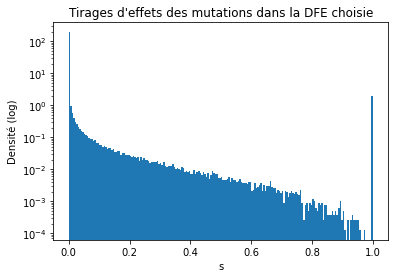

In [65]:
np.random.seed(0)    # graîne pour les générateurs aléatoires

# Combiner différentes densités pour former une DFE mixte
dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
           np.ones(mut_shape))                               # mutations létales
#dty_mix = (np.random.beta(alpha1,beta1, mut_shape),
#           np.random.beta(alpha2,beta2, mut_shape),
#           np.ones(mut_shape))                               

weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité
#weights = np.array([(1-lethal_mut_proba)/2,(1-lethal_mut_proba)/2, lethal_mut_proba])   # poids de chaque densité

s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=weights, size=mut_shape), choices = dty_mix)

plt.hist(np.concatenate(s), bins=200, log=True, density=True)
plt.title("Tirages d'effets des mutations dans la DFE choisie")
plt.xlabel("s")
plt.ylabel("Densité (log)")
plt.show()

In [67]:
# Effets relatifs des mutations sur la fitness
fitness_effects = (1 - s)
fitness_effects.shape

(1066, 1476)

In [68]:
cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)          # effets relatifs cumulés des mutations
growthR_steps_sim = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init))   # évolution du taux de croissance mutation par mutation

growthR_steps_sim

array([[0.03247045, 0.03284871, 0.0281195 , ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247045, 0.03284871, 0.02803682, ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247045, 0.03284871, 0.02803682, ..., 0.02662032, 0.02952523,
        0.02556724],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

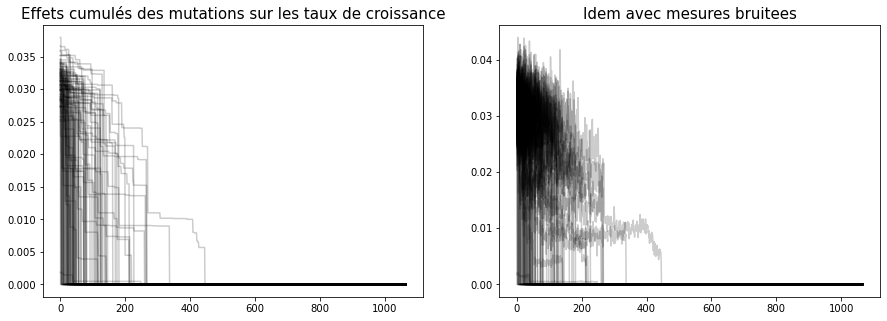

In [69]:
growthR_steps_sim_noise = np.vstack((growthR_init, 
                                     cumulative_fitness_effects*growthR_init*(1+np.random.normal(0, sd_noise, size=mut_shape))))
growthR_steps_sim_noise[growthR_steps_sim_noise<0] = 0

im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(growthR_steps_sim[:,:100], color="black", alpha=0.2)
ax1.set_title("Effets cumulés des mutations sur les taux de croissance",fontsize=15)
ax2.plot(growthR_steps_sim_noise[:,:100], color="black", alpha=0.2)
ax2.set_title("Idem avec mesures bruitees",fontsize=15)
plt.show()

In [70]:
np.random.seed(0)

if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
    exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    #print(exponential_intervals)
else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
    mutation_rate_t = growthR_steps_sim[:-1]/np.mean(growthR_init) * mutation_rate
    exponential_intervals = np.random.exponential(1/mutation_rate_t)
    exponential_intervals[np.isinf(exponential_intervals)] = exp_duration

mutation_time = np.cumsum(exponential_intervals, axis=0)  # temps d'apparition de chaque mutation, en minutes
print(np.shape(mutation_time))

#plt.hist(mutation_time[-1,:])
#plt.vlines(exp_duration, 0, 300, colors="red", linestyles="dashed")
#plt.title("Distribution des durées d'expériences in silico")
#plt.xlabel("Temps (min)")
#plt.show()

# Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
assert min(mutation_time[-1,:]) > exp_duration, "Ajouter plus de mutations, simulations trop courtes : " + str(mutation_time[-1,mutation_time[-1,:]<exp_duration])

(1066, 1476)


<ipython-input-70-94187d96a807>:8: RuntimeWarning: divide by zero encountered in true_divide
  exponential_intervals = np.random.exponential(1/mutation_rate_t)


In [71]:
growthR_sim = []
growthR_sim_noise = []
for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
    # Identifier après quelle mutation la mesure est faite
    cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
    # Prendre la valeur de taux de croissance associé à cette mutation
    growthR_sim.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim[1:,i]))
    growthR_sim_noise.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim_noise[1:,i]))

growthR_sim = np.array(growthR_sim).T
growthR_sim_noise = np.array(growthR_sim_noise).T
growthR_sim.shape

In [73]:
growthR_sim.shape

(10000, 1476)

In [74]:
from scipy.stats import gaussian_kde

In [75]:
xmin=0
xmax=0.14
ymin=0
ymax=250
nbreaks=200


#lambd=0.1 # paramètre de la loi de Poisson
#Nt=0 # nombre de mutations avant le temps t

#seuil_detection_fitness=0.0005

In [76]:
def get_y(x,growthR_cur,eps): # trouve la hauteur de la barre de l'histogramme correspondant à [x-eps/2,x+eps/2]
    y=[]
    i=0
    j=0
    for x_cur in x:
        while x_cur-growthR_cur[i]>eps/2 and i<len(growthR_cur)-1: i+=1
        while growthR_cur[j]-x_cur<eps/2 and j<len(growthR_cur)-1: j+=1
        y+=[j-i]
    return y

def get_dist_s(growthR_real): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=[]
    for i in range(2,len(growthR_real)-1):
        for j in range(len(growthR_real[i])): 
            wv=(growthR_real[i])[j]
            wn=(growthR_real[i+1])[j]
            if wv!=0:
                s+=[(wv-wn)/wv]
    return s

def sort_rows(w): # pour optimiser la construction de l'histogramme
    res=[]
    for row in w:
        res+=[np.sort(row)]
    return res
    
def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[0] # JJ   attention, pb à régler un jour!
    return res

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
line1,line2,=ax.plot([], [], [], [])
line = [line1,line2]
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

In [78]:
ax.legend(["Processus simulé"])

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim=get_y(x,np.sort(growthR_sim[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=1)

# Set up formatting for the movie files
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=100, bitrate=1000)
#ani.save('Video/GrowthRates_simulations_VS_observations.mp4', writer=writer)

#Video('Video/GrowthRates_simulations_VS_observations.mp4')
HTML(ani.to_html5_video())